<a href="https://colab.research.google.com/github/iskra3138/ImageSr/blob/master/MVTEC_DEMO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### MVTEC Leather Data Grad-CAM 계열 적용 데모
- GradCAM, GuidedGradCAM Class에 Batch 데이터 적용 함수 추가
- 예측결과와 정답/오답 여부 표시 추가

In [0]:
!nvidia-smi ## 배정받은 GPU 확인 (P100이 가장 빠르고 K80이 가장 느림)

In [0]:
#@title DEMO 준비_ 사전실행 [Run Me!!!!]

!gsutil cp gs://iskra3138_mvtec_tfrecords/my_mvtec_tpumodel.h5 ./
  
model_file = 'my_mvtec_tpumodel.h5'
activation_layer = 'conv5_block3_out'

%tensorflow_version 1.x

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from PIL import Image as Image
import cv2

import glob

import tensorflow as tf
from tensorflow.python.keras.models import model_from_json
from tensorflow.python.keras import backend as K
from tensorflow.python.framework import ops


import scipy
from scipy import ndimage
from skimage.measure import label, regionprops

%matplotlib inline

model = tf.keras.models.load_model(model_file)

#@title TFRecord Parsing Functions [Run Me!!!!]
import os

AUTO = tf.data.experimental.AUTOTUNE

IMAGE_SIZE =  [224, 224]

validation_fns = 'gs://iskra3138_mvtec_tfrecords/valid.tfrecords'

def parse_tfrecord(example):
    features = {
        'height': tf.io.FixedLenFeature([], tf.int64),
        'width': tf.io.FixedLenFeature([], tf.int64),
        'depth': tf.io.FixedLenFeature([], tf.int64),
        'label': tf.io.FixedLenFeature([], tf.int64),
        'image_raw': tf.io.FixedLenFeature([], tf.string),
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    
    label = example['label']
    #label = tf.one_hot(indices=label, depth=2)
    image = tf.io.decode_jpeg(example['image_raw'], channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, IMAGE_SIZE)
    
    return image, label

def load_dataset(filenames):
  # Read from TFRecords. For optimal performance, we interleave reads from multiple files.
  records = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
  return records.map(parse_tfrecord, num_parallel_calls=AUTO)

def NG_filter_fn(img, label):
  return tf.math.equal(label, 0)
def OK_filter_fn(img, label):
  return tf.math.equal(label, 1)

def make_class_sapling (fns, class_idx, batch_size) :
  if class_idx == 0 :
    NG_dataset = load_dataset(fns).filter(NG_filter_fn).shuffle(1000).batch(batch_size).prefetch(AUTO).repeat()
    NG_iter = NG_dataset.make_one_shot_iterator()
    return NG_iter
  else :
    OK_dataset = load_dataset(fns).filter(OK_filter_fn).shuffle(1000).batch(batch_size).prefetch(AUTO).repeat()
    OK_iter = OK_dataset.make_one_shot_iterator()
    return OK_iter
    
    
#@title import Util Code [Run Me!!]
def deprocess_image(x):
    '''
    Same normalization as in:
    https://github.com/fchollet/keras/blob/master/examples/conv_filter_visualization.py
    '''
    if np.ndim(x) > 3:
        x = np.squeeze(x)
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if tf.keras.backend.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def generate_bbox(img, cam, threshold):
    labeled, nr_objects = ndimage.label(cam > threshold)
    props = regionprops(labeled)
    return props

  
CLASSES = ['NG', 'OK']  
def img_title(label, prediction):
  # Both prediction (probabilities) and label (one-hot) are arrays with one item per class.
  class_idx = np.argmax(label, axis=-1)
  prediction_idx = np.argmax(prediction, axis=-1)
  if class_idx == prediction_idx:
    return f'{CLASSES[prediction_idx]} [correct]', 'black'
  else:
    return f'{CLASSES[prediction_idx]} [incorrect, should be {CLASSES[class_idx]}]', 'red'

def get_titles(labels, predictions):
  titles, colors = [], []
  for label, prediction in zip(labels, predictions):
    title, color = img_title(label, prediction)
    titles.append(title)
    colors.append(color)
  return titles, colors

#@title import Grad-CAM Code [Run Me!!]
class GradCAM:
  def __init__(self, model, activation_layer):
    self.model = model
    self.activation_layer = activation_layer
    self.gradient_fn = self._get_gradcam_tensor_function()

  # get partial tensor graph of CNN model
  def _get_gradcam_tensor_function(self):
    model_input = self.model.input
    class_idx = tf.argmax(model.output[0])
    
    y_c = self.model.outputs[0].op.inputs[0][:, class_idx]
    A_k = self.model.get_layer(self.activation_layer).output
    
    grads = K.gradients(y_c, A_k)[0]
    gradient_fn = K.function([model.input], [A_k, grads, model.output])
    return gradient_fn

  # generate Grad-CAM
  def single_generate(self, input_tensor):
    '''
    input_tensor : 3D-array (H, W, C)
    '''
    input_tensor = np.expand_dims(input_tensor, axis=0)
    conv_output, grad_val, predictions = self.gradient_fn([input_tensor])
    conv_output, grad_val = conv_output[0], grad_val[0]
    
    weights = np.mean(grad_val, axis=(0, 1))
    gradcam = np.dot(conv_output, weights)
    
    gradcam = cv2.resize(gradcam, (224, 224))
    
    ## Relu
    gradcam = np.maximum(gradcam, 0)
    return gradcam, predictions[0]
  
  def batch_generate(self, input_tensors):
    '''
    input_tensors : 4D-array (Batch, H, W, C)
    gradcams : 3D-array (Batch, H, W)
    '''  
    conv_output, grad_val, predictions = self.gradient_fn([input_tensors])
    conv_outputs, grad_vals = conv_output, grad_val

    weights = np.mean(grad_vals, axis=(1, 2))
    gradcams =[]
    for i in range(conv_outputs.shape[0]) :
      gradcam = np.dot(conv_outputs[i], weights[i])
      gradcam = cv2.resize(gradcam, (224, 224))
      ## Relu
      gradcam = np.maximum(gradcam, 0)
      gradcams.append(gradcam)

    return gradcams, predictions
  
#@title import Guided Grad-CAM Code [Run Me!!]
class GuidedGradCam:
    def __init__(self, model, activation_layer, method='GuidedBackProp'):
        self.model = model
        #self.model_func = model_func
        self.activation_layer = activation_layer

        if method == 'BackProp':
            self._register_backprop_gradient()
            self.guided_model = self._modify_graph('BackProp')
        elif method == 'DeconvNet':
            self._register_deconvnet_gradient()
            self.guided_model = self._modify_graph('DeconvNet')
        elif method == 'GuidedBackProp':
            self._register_guidedbackprop_gradient()
            self.guided_model = self._modify_graph('GuidedBackProp')
        else:
            sys.exit('method must be (BackProp, DeconvNet, GuidedBackProp)')

        self.tensor_function = self.get_tensor_function()

    # register gradient
    def _register_backprop_gradient(self):
        if "BackProp" not in ops._gradient_registry._registry:
            @ops.RegisterGradient("BackProp")
            def _BackProp(op, grad):
                dtype = op.inputs[0].dtype
                return grad * tf.cast(op.inputs[0] > 0., dtype)

    def _register_deconvnet_gradient(self):
        if "DeconvNet" not in ops._gradient_registry._registry:
            @ops.RegisterGradient("DeconvNet")
            def _DeconvNet(op, grad):
                dtype = op.inputs[0].dtype
                return grad * tf.cast(grad > 0., dtype)

    def _register_guidedbackprop_gradient(self):
        if "GuidedBackProp" not in ops._gradient_registry._registry:
            @ops.RegisterGradient("GuidedBackProp")
            def _GuidedBackProp(op, grad):
                dtype = op.inputs[0].dtype
                return grad * tf.cast(grad > 0., dtype) * \
                       tf.cast(op.inputs[0] > 0., dtype)

    # modify model graph
    def _modify_graph(self, name):
        g = tf.get_default_graph()
        with g.gradient_override_map({'Relu': name}):
            new_model = tf.keras.models.load_model('my_mvtec_tpumodel.h5')
        return new_model

    # get partial tensor graph of CNN model
    def get_tensor_function(self, method='max', channel=0):
        model_input = self.guided_model.input
        layer_output = self.guided_model.get_layer(self.activation_layer).output

        '''if method == 'max':
            output = K.max(layer_output, axis=3)
        elif method == 'one':
            output = layer_output[:, :, :, channel]
        else:
            sys.exit('method must be (max, one)')'''

        tensor_function = K.function([model_input], [K.gradients(layer_output, model_input)[0]])
        return tensor_function

    # generate saliency map(gradient)
    def single_generate(self, input_tensor, gradcam): 
        '''
        input_tensor : 3D-array (H, W, C)
        '''
        input_tensor = np.expand_dims(input_tensor, axis=0)
        saliency = self.tensor_function([input_tensor])[0]
        guided_grad_cam = saliency * gradcam[...,np.newaxis]

        return guided_grad_cam[0]
      
    # generate saliency map(gradient)
    def batch_generate(self, input_tensors, gradcams):
        '''
        input_tensors : 4D-array (Batch, H, W, C)
        gradcams : 3D-array (Batch, H, W)
        '''   
        saliencies = self.tensor_function([input_tensors])[0]
        guided_grad_cams =[]
        for i in range(len(gradcams)) :
          guided_grad_cam = saliencies[i] * gradcams[i][...,np.newaxis]
          guided_grad_cams.append(guided_grad_cam)
        return guided_grad_cams
      
gradcam_gen = GradCAM(model, activation_layer)
guided_gradcam_gen = GuidedGradCam(model, activation_layer)  

,,,
,,,
,,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

image


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

gradcam


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

BBOX


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

guided_gradcam


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

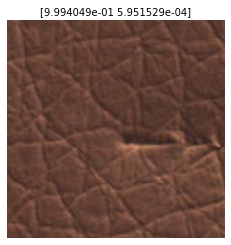

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

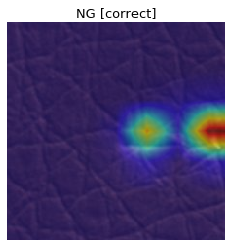

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

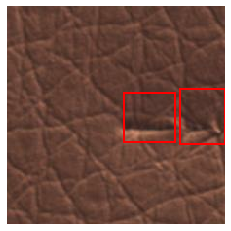

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

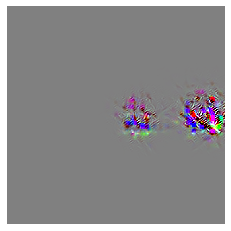

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

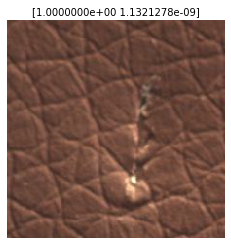

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

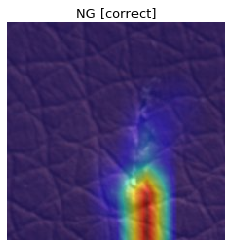

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

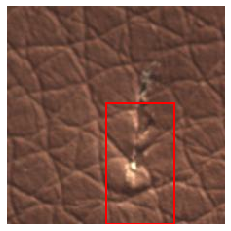

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

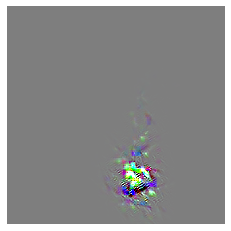

<IPython.core.display.Javascript object>

In [3]:
#@title NG Image TEST DEMMO [Run Me!!!!]
from google.colab import widgets

sample_size = 2 # viualization할 이미지 개수
class_idx = 0 # NG면 0, OK면 1

NG_iter = make_class_sapling(validation_fns, class_idx = class_idx, batch_size = sample_size)
NG_images, NG_labels = NG_iter.get_next()

with tf.Session() as sess:
  images, labels = sess.run([NG_images, NG_labels])
  
gradcams, preds = gradcam_gen.batch_generate(images)
guided_gradcams = guided_gradcam_gen.batch_generate(images, gradcams)

titles, colors = get_titles(np.eye(len(CLASSES))[labels], preds)
    
grid = widgets.Grid(sample_size+1, 4, header_row=True, header_column=True)
for i, title in enumerate(['image', 'gradcam', 'BBOX', 'guided_gradcam']):
  with grid.output_to(0, i):
    print (title)

for i, img in enumerate(images):
    props = generate_bbox(img, gradcams[i], 0.5) # (원본이미지, gradcam값, BBOX 작성을 위한 threshold)
    with grid.output_to(i+1, 0):
      plt.imshow(img)
      plt.title(str(preds[i]), fontsize=10)
      plt.axis('off')
    with grid.output_to(i+1, 1):  
      plt.imshow(img)
      plt.imshow(gradcams[i], cmap='jet', alpha=0.5)
      plt.title(titles[i], fontsize=13, color=colors[i])
      plt.axis('off')
    with grid.output_to(i+1, 2):
      fig,ax = plt.subplots(1, figsize=(4, 4))
      ax.imshow(img)
      for b in props:
        bbox = b.bbox
        xs = bbox[1]
        ys = bbox[0]
        w = bbox[3] - bbox[1]
        h = bbox[2] - bbox[0]

        rect = patches.Rectangle((xs, ys), w, h, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
      ax.axis('off')
    with grid.output_to(i+1, 3):
      plt.imshow(deprocess_image(guided_gradcams[i]))
      plt.axis('off')

,,,
,,,
,,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

image


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

gradcam


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

BBOX


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

guided_gradcam


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

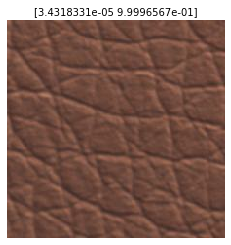

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

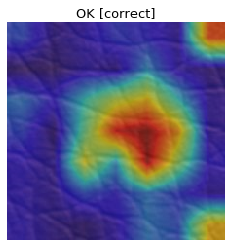

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

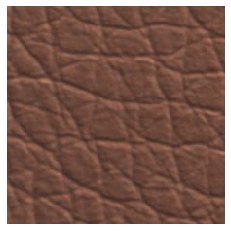

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

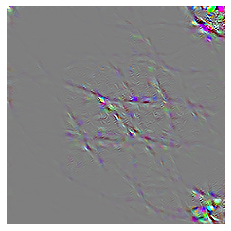

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

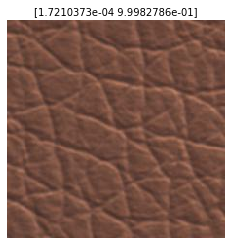

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

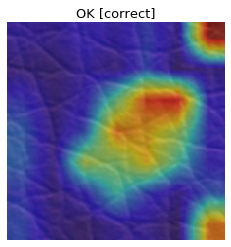

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

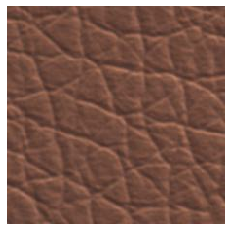

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

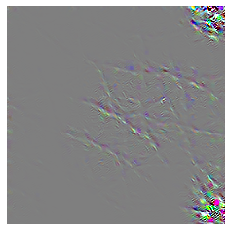

<IPython.core.display.Javascript object>

In [4]:
#@title OK Image TEST DEMMO [Run Me!!!!]
from google.colab import widgets

sample_size = 2 # viualization할 이미지 개수
class_idx = 1 # NG면 0, OK면 1
OK_iter = make_class_sapling(validation_fns, class_idx = class_idx, batch_size = sample_size)
OK_images, OK_labels = OK_iter.get_next()

with tf.Session() as sess:
  images, labels = sess.run([OK_images, OK_labels])
  
gradcams, preds = gradcam_gen.batch_generate(images)
guided_gradcams = guided_gradcam_gen.batch_generate(images, gradcams)

titles, colors = get_titles(np.eye(len(CLASSES))[labels], preds)
    
grid = widgets.Grid(sample_size+1, 4, header_row=True, header_column=True)
for i, title in enumerate(['image', 'gradcam', 'BBOX', 'guided_gradcam']):
  with grid.output_to(0, i):
    print (title)

for i, img in enumerate(images):
    props = generate_bbox(img, gradcams[i], 0.5) # (원본이미지, gradcam값, BBOX 작성을 위한 threshold)
    with grid.output_to(i+1, 0):
      plt.imshow(img)
      plt.title(str(preds[i]), fontsize=10)
      plt.axis('off')
    with grid.output_to(i+1, 1):  
      plt.imshow(img)
      plt.imshow(gradcams[i], cmap='jet', alpha=0.5)
      plt.title(titles[i], fontsize=13, color=colors[i])
      plt.axis('off')
    with grid.output_to(i+1, 2):
      fig,ax = plt.subplots(1, figsize=(4, 4))
      ax.imshow(img)
      for b in props:
        bbox = b.bbox
        xs = bbox[1]
        ys = bbox[0]
        w = bbox[3] - bbox[1]
        h = bbox[2] - bbox[0]

        rect = patches.Rectangle((xs, ys), w, h, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
      ax.axis('off')
    with grid.output_to(i+1, 3):
      plt.imshow(deprocess_image(guided_gradcams[i]))
      plt.axis('off')